<a href="https://colab.research.google.com/github/reyllama/TTIO/blob/master/07_BackTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modulate

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data = pd.read_csv("/content/drive/My Drive/core_stocks.csv", dtype={'stock_id': str})
data['stock_id'] = data['stock_id'].astype(str)

In [3]:
def data_preparer(n=1, n_epochs=120, lr=0.05, silent=False, corr=True):
    if corr:
        path = "/content/drive/My Drive/corr{0}.csv".format(n)
    if not corr:
        path = "/content/drive/My Drive/cov{0}.csv".format(n)
    df = pd.read_csv(path)
    df = df.set_index(keys='stock_id')
    df.columns = df.columns.astype(str)
    df.index = df.index.astype(str)

    if n==1:
        st, ed = 1, 121
    elif n==2:
        st, ed = 62, 186
    elif n==3:
        st, ed=124,248
    elif n==4:
        st, ed=186,310
    elif n==5:
        st, ed=248, 368
    elif n==6:
        st, ed=310, 432
    elif n==7:
        st, ed=368,489
    elif n==8:
        st, ed=432, 550
    else:
        print("Too Big A Number")
        return None

    embeddings = get_embeddings(corr_df=df, n_epochs=n_epochs, lr=lr, silent=silent)

    return df, embeddings, st, ed

In [4]:
def get_embeddings(corr_df=None, n_epochs=100, dim=32, lr=0.01, silent=False):
  dtype = torch.FloatTensor
  epochs = n_epochs
  emb_dim = dim
  embeddings = Variable(torch.randn(emb_dim, len(corr_df)).type(dtype), requires_grad=True)
  lr = lr
  optimizer = optim.Adam([embeddings], lr=lr)
  mean = np.abs(corr_df).mean().mean()
  coef = 1/mean # Hyper Parameter 변경
  loss_track = []

  for epoch in range(epochs):
    loss = 0
    for i in range(len(corr_df)):
      v1 = embeddings[:, i].view(emb_dim, -1)
      dist = torch.norm(v1 - embeddings, dim=0).view(len(corr_df), 1)
      corrs = torch.from_numpy(np.abs(coef*np.array(corr_df.iloc[:, i]))-1).view(1, len(corr_df)).type(torch.FloatTensor)
    #   corrs = torch.from_numpy(np.array(df.iloc[:, i])).view(1, len(df)).type(torch.FloatTensor) # rho 교수님 버전
      loss += torch.mm(corrs, dist)/2

    #   v1 = embeddings[:, i].view(-1, emb_dim)
    #   mm = torch.mm(v1, embeddings)
    #   mm[:, i] = torch.zeros(1) # 자기 자신과의 dot product은 0으로 만들어줌. 그렇지 않으면 각각이 다 0 벡터가 될 우려
    #   corrs = torch.from_numpy(coef*np.array(df.iloc[:, i])).view(len(df), 1).type(torch.FloatTensor)
    #   loss += torch.mm(mm, corrs)

    loss_track.append(loss.item())
    if not silent:
        if (epoch+1) % 20 == 0:
            print("{0}th epoch in process".format(epoch+1))
            print('running loss: {}'.format(loss.item()))
            print()

    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()

    with torch.no_grad():
      for element in embeddings:
        element.clamp_(0,1)

  return embeddings

In [5]:
!pip install ta
import ta

def bias(close=None, m=7):
  return close - close.rolling(m).mean()

def preprocessing(data=data, start=125, end=125+62, corr_df = None):

  data['stock_id'] = data['stock_id'].astype(str)
  data['year'] = data['date'].apply(lambda x: int(x[0:4]))
  data['month'] = data['date'].apply(lambda x: int(x[5:7]))

  data = data[(data['date_index']<=end)&(data['date_index']>=start)]
  data = data[data['stock_id'].isin(df.columns)]

  data['KLength'] = data['closing_price'] - data['opening_price']
  data['KUpperLength'] = data['highest_price'] - data[['opening_price', 'closing_price']].max(axis=1)
  data['temp'] = data['opening_price']-data['lowest_price']
  data['KLowerLength'] = data[['closing_price', 'temp']].min(axis=1)
  data['return'] = data['closing_price'].diff()
  data = data.drop(columns=['temp'])

  data['EMA'] = ta.trend.ema_indicator(close=data['closing_price'])
  data['MACD'] = ta.trend.macd(close=data['closing_price'])
  data['ROC'] = ta.momentum.roc(close=data['closing_price'])
  data['BIAS'] = bias(data['closing_price'])
  

  return data

  Created wheel for ta: filename=ta-0.5.25-cp36-none-any.whl size=24880 sha256=349bb181672ddb5c193e9e74d4e481314870972c74cbd069c309575641461793
  Stored in directory: /root/.cache/pip/wheels/2e/93/b7/cf649194508e53cee4145ffb949e9f26877a5a8dd12db9ed5b
Successfully built ta


In [6]:
def rescale_factor(train_data=None, valid_data=None, indicator='KLength', lr=0.005, n_epochs=3000, embeddings=None):
    KL = train_data.pivot(index='date', columns='stock_id', values=indicator)
    R = train_data.pivot(index='date', columns='stock_id', values='return')
    v1 = valid_data.pivot(index='date', columns='stock_id', values=indicator)
    v2 = valid_data.pivot(index='date', columns='stock_id', values='return')

    if indicator in ['KLength', 'KUpperLength', 'KLowerLength']:
        KL = KL.iloc[:-1, ]
        R = R.iloc[1:, ]
        v1 = v1.iloc[:-1, ]
        v2 = v2.iloc[1:, ]
    elif indicator == 'EMA':
        KL = KL.iloc[11:-1, ]
        R = R.iloc[12:, ]
        v1 = v1.iloc[11:-1, ]
        v2 = v2.iloc[12:, ]
    elif indicator == 'MACD':
        KL = KL.iloc[25:-1, ]
        R = R.iloc[26:, ]
        v1 = v1.iloc[25:-1, ]
        v2 = v2.iloc[26:, ]
    elif indicator == 'ROC':
        KL = KL.iloc[12:-1, ]
        R = R.iloc[13:, ]
        v1 = v1.iloc[12:-1, ]
        v2 = v2.iloc[13:, ]
    elif indicator == 'BIAS':
        KL = KL.iloc[6:-1, ]
        R = R.iloc[7:, ]
        v1 = v1.iloc[6:-1, ]
        v2 = v2.iloc[7:, ]
    else:
        print('Unknown Indicator!')
        return None

    dtype = torch.FloatTensor
    weights = Variable(torch.randn(1, 32).type(dtype), requires_grad=True)
    lr = lr
    optimizer = optim.Adam([weights], lr=lr)
    epochs = n_epochs
    indic = np.array(KL)
    returns = np.array(R)
    v_ind = np.array(v1)
    v_ret = np.array(v2)
    base_loss = np.Inf
    final_factor = None

    for epoch in range(epochs):
        loss = 0

        rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
        opt_ind = torch.from_numpy(indic) * rescale_fc # element-wise
        mean_ind = torch.mean(opt_ind, axis=0)
        mean_ret = torch.mean(torch.from_numpy(returns), axis=0)

        vx = opt_ind - mean_ind
        vy = torch.from_numpy(returns) - mean_ret
        loss = -torch.abs(torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))))

        if (epoch+1) % 1000 == 0:
            print("{0}th epoch in process".format(epoch+1))

        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()

##### 이부분 Indentation 당겼더니 성능 좋았음 #############

        with torch.no_grad():

            # for weight in weights:
            #     weight.clamp_(0,1)

            v_opt = (torch.from_numpy(v_ind) * rescale_fc).detach().numpy()
            v_mean_ind = np.mean(v_opt, axis=0)
            v_mean_ret = np.mean(v_ret, axis=0)
            ux = v_opt - v_mean_ind
            uy = v_ret - v_mean_ret
            v_loss = -np.abs(np.sum(ux * uy) / (np.sqrt(np.sum(ux ** 2)) * np.sqrt(np.sum(uy ** 2))))
            if v_loss < base_loss:
                base_loss = v_loss
                final_factor = rescale_fc

#############################################################

    return final_factor

In [7]:
def K_selector(data=None, corr_df=None, start=None, end=None, window=62, embeddings=None, e=5, silent=False):
    from collections import defaultdict
    train_df = preprocessing(data=data, corr_df=corr_df, start=start, end=end)
    valid_df = preprocessing(data=data, corr_df=corr_df, start=end+1, end=end+window)
    # test_df = preprocessing(data=data, corr_df=corr_df, start=end+window+1, end=end+2*window)
    first_term = pd.concat([train_df, valid_df])
    indicators=['EMA', 'MACD', 'KLength', 'KUpperLength', 'KLowerLength', 'ROC', 'BIAS']
    result = defaultdict(list)

    for k in range(16, 26): # Selecting Top K

        for indicator in indicators: # Out of 7 Indicators

            j, s, = 0, 0 # To average the results
            rescale_fc = rescale_factor(indicator=indicator, train_data=train_df, valid_data=valid_df, embeddings=embeddings, n_epochs=80, lr=0.05)

            for _ in range(e): # Number of backtests to conduct, averaging out later

                cap = 1e7 # Seed Capital
                base_cap = 1e7
                a,b = [1e7], [1e7] # Trajectory of capital possession

                for day in range(end, end+window-1):

                    base_top10 = np.array(first_term[first_term['date_index']==day][indicator]).T.argsort()[-k:][::-1]
                    base_top10_close = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['closing_price']
                    base_top10_open = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['opening_price']
                    base_cap += ((base_top10_close*0.997 - base_top10_open)/base_top10_open*base_cap/k).sum()
                    a.append(base_cap)

                    #Parallel Universe
                    temp = rescale_fc.detach().numpy() * np.array(first_term[first_term['date_index']==day][indicator]).T # elementwise
                    top10 = temp.squeeze().argsort()[-k:][::-1]
                    top10_close = first_term[first_term['date_index']==day+1].iloc[top10, :]['closing_price']
                    top10_open = first_term[first_term['date_index']==day+1].iloc[top10, :]['opening_price']
                    # print((top10_close*0.997 - top10_open)/top10_open*0.1*cap)
                    cap += ((top10_close*0.997 - top10_open)/top10_open*cap/k).sum()
                    b.append(cap)

                j += a[-1]
                s += b[-1]
            if not silent:
                print("Top {0} 기준 Raw 수익과 Rescaled 수익은 각각 {2:.2f} // {3:.2f} ({1})".format(k, indicator, j/e, s/e))

            result['K'].append(k)
            result['indicator'].append(indicator)
            result['raw'].append(j/e)
            result['scaled'].append(s/e)

    return result

In [8]:
output = pd.read_csv('/content/drive/My Drive/backtest_topK_ROBUST_extended.csv')
# pd.DataFrame(columns=['K', 'indicator', 'raw', 'scaled'])
output.head()

,K,indicator,raw,scaled
0,3,EMA,8.727141e+06,9.323621e+06
1,3,MACD,8.485460e+06,6.743897e+06
2,3,KLength,7.251680e+06,8.427762e+06
3,3,KUpperLength,7.870096e+06,7.069560e+06
4,3,KLowerLength,8.211525e+06,7.091046e+06


In [9]:
import warnings
warnings.filterwarnings('ignore')
import time

for n_ in range(1, 9):

    t0 = time.time()
    df, embeddings, st, ed = data_preparer(n=n_, n_epochs=100, lr=0.05, silent=True, corr=True)
    print('{} embedding done'.format(n_))
    t1 = time.time()
    result_dict = K_selector(data=data, corr_df=df, start=st, end=ed, window=62, embeddings=embeddings, e=40, silent=True)
    output = pd.concat([output, pd.DataFrame(data=result_dict)])
    print('{} period done'.format(n_))
    t2 = time.time()
    print("Embedding 획득 {0:.1f} / 총 소요 시간 {1:.1f}".format((t1-t0)/60, (t2-t0)/60))
output

1 embedding done
1 period done
Embedding 획득 2.6 / 총 소요 시간 34.7
2 embedding done
2 period done
Embedding 획득 2.6 / 총 소요 시간 35.7
3 embedding done
3 period done
Embedding 획득 2.7 / 총 소요 시간 37.7
4 embedding done
4 period done
Embedding 획득 2.8 / 총 소요 시간 38.0
5 embedding done
5 period done
Embedding 획득 2.8 / 총 소요 시간 38.0
6 embedding done
6 period done
Embedding 획득 2.8 / 총 소요 시간 37.2
7 embedding done
7 period done
Embedding 획득 2.7 / 총 소요 시간 36.6
8 embedding done
8 period done
Embedding 획득 2.8 / 총 소요 시간 37.2


,K,indicator,raw,scaled
0,3,EMA,8.727141e+06,9.323621e+06
1,3,MACD,8.485460e+06,6.743897e+06
2,3,KLength,7.251680e+06,8.427762e+06
3,3,KUpperLength,7.870096e+06,7.069560e+06
4,3,KLowerLength,8.211525e+06,7.091046e+06
...,...,...,...,...
65,25,KLength,6.765667e+06,7.092521e+06
66,25,KUpperLength,7.871022e+06,8.682978e+06
67,25,KLowerLength,8.663189e+06,7.941100e+06
68,25,ROC,6.930024e+06,7.335590e+06


In [10]:
output.to_csv('/content/drive/My Drive/backtest_topK_ROBUST_EXTENDED.csv', index=False)

In [12]:
output = output.reset_index(drop=True)
output

,K,indicator,raw,scaled
0,3,EMA,8.727141e+06,9.323621e+06
1,3,MACD,8.485460e+06,6.743897e+06
2,3,KLength,7.251680e+06,8.427762e+06
3,3,KUpperLength,7.870096e+06,7.069560e+06
4,3,KLowerLength,8.211525e+06,7.091046e+06
...,...,...,...,...
723,15,KLength,6.479712e+06,7.792648e+06
724,15,KUpperLength,7.218022e+06,7.708821e+06
725,15,KLowerLength,8.539077e+06,7.454110e+06
726,15,ROC,6.383879e+06,7.094786e+06


In [13]:
output['diff'] = output['scaled'] - output['raw']

In [14]:
output.groupby('K')[['scaled', 'raw', 'diff']].mean()

,scaled,raw,diff
K,,,
3,7.633402e+06,7.896995e+06,-263592.581046
4,7.621752e+06,7.864658e+06,-242906.086432
5,7.962370e+06,7.823535e+06,138834.769139
6,7.707602e+06,7.826464e+06,-118861.914128
7,7.751267e+06,7.789046e+06,-37779.459054
8,7.756280e+06,7.762648e+06,-6367.739631
9,7.822538e+06,7.719269e+06,103268.957051
10,7.899276e+06,7.733220e+06,166056.382173
11,7.767258e+06,7.711097e+06,56161.414185


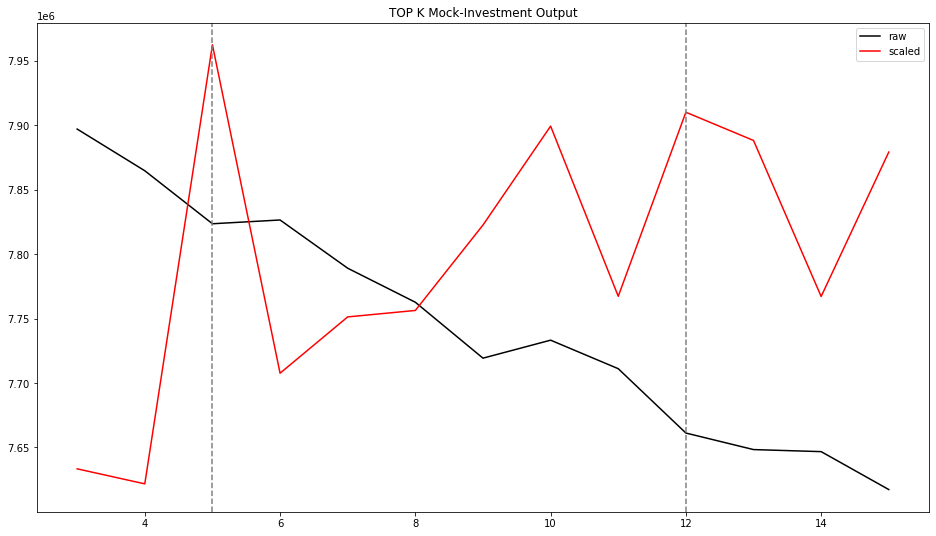

In [19]:
plt.figure(figsize=(16,9))
plt.title("TOP K Mock-Investment Output")
xx = list(range(3, 16))
yy = output.groupby('K')[['scaled', 'raw', 'diff']].mean()
plt.plot(xx, yy['raw'], color='k', label='raw')
plt.plot(xx, yy['scaled'], color='red', label='scaled')
# plt.bar(xx, yy['diff'], color='gray', label='difference')
plt.axvline(x=5, color='gray', ls='--')
plt.axvline(x=12, color='gray', ls='--')
plt.legend()
plt.savefig('backtest_topK_ROBUST_extended_plot.png')
plt.show()

## 지금까지 정리

- 2016년~2017년 2년짜리 Back Testing
- 6개월로 임베딩 및 Rescale Factor 산정하고, 이후 3개월 동안 매일매일 Top K개 주식 시가에 구매, 종가에 판매, 0.3% 수수료 포함
- Corr 기준, Loss = |c*rho - 1|x||v_i - v_j||, K=8, 가장 좋은 성능

In [ ]:
def backtest(data=None, corr_df=None, start=None, end=None, window=65, embeddings=None, e=5, silent=False, k=8):

    from collections import defaultdict

    first_term = preprocessing(data=data,corr_df=corr_df, start=start, end=end+2*window)
    train_df = first_term[first_term['date_index'].isin(list(range(start, end+1)))]
    valid_df = first_term[first_term['date_index'].isin(list(range(end+1, end+window+1)))]
    # test_df = raw_df[raw_df['date_index'].isin(list(range(end+window+1, end+2*window+1)))]
    indicators=['EMA', 'MACD', 'KLength', 'KUpperLength', 'KLowerLength', 'ROC', 'BIAS']

    result = defaultdict(list)

    for indicator in indicators: # Out of 7 Indicators

        j, s, = 0, 0 # To average the results
        rescale_fc = rescale_factor(indicator=indicator, train_data=train_df, valid_data=valid_df, embeddings=embeddings, n_epochs=80, lr=0.05)

        for _ in range(e): # Number of backtests to conduct, averaging out later

            cap = 1e7 # Seed Capital
            base_cap = 1e7
            a,b = [1e7], [1e7] # Trajectory of capital possession

            for day in range(end+window, end+2*window):

                base_top10 = np.array(first_term[first_term['date_index']==day][indicator]).T.argsort()[-k:][::-1]
                base_top10_close = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['closing_price']
                base_top10_open = first_term[first_term['date_index']==day+1].iloc[base_top10, :]['opening_price']
                base_cap += ((base_top10_close*0.997 - base_top10_open)/base_top10_open*base_cap/k).sum()
                a.append(base_cap)

                    #Parallel Universe
                temp = rescale_fc.detach().numpy() * np.array(first_term[first_term['date_index']==day][indicator]).T # elementwise
                top10 = temp.squeeze().argsort()[-k:][::-1]
                top10_close = first_term[first_term['date_index']==day+1].iloc[top10, :]['closing_price']
                top10_open = first_term[first_term['date_index']==day+1].iloc[top10, :]['opening_price']
                    # print((top10_close*0.997 - top10_open)/top10_open*0.1*cap)
                cap += ((top10_close*0.997 - top10_open)/top10_open*cap/k).sum()
                b.append(cap)

            j += a[-1]
            s += b[-1]
        if not silent:
            print("Top {0} 기준 Raw 수익과 Rescaled 수익은 각각 {2:.2f} // {3:.2f} ({1})".format(k, indicator, j/e, s/e))

        result['start'].append(start)
        result['end'].append(end)
        result['indicator'].append(indicator)
        result['raw'].append(j/e)
        result['scaled'].append(s/e)

    return result

In [ ]:
backtest_output = pd.DataFrame(columns=['start', 'end', 'indicator', 'raw', 'scaled'])

for n_ in range(1, 9):

    df, embeddings, st, ed = data_preparer(n=n_, n_epochs=100, lr=0.05, silent=True, corr=True)
    result_dict = backtest(data=data, corr_df=df, start=st, end=ed, window=62, embeddings=embeddings, e=5, silent=True, k=5)
    backtest_output = pd.concat([backtest_output, pd.DataFrame(data=result_dict)])
backtest_output

,start,end,indicator,raw,scaled
0,1,121,EMA,8.765007e+06,8.608307e+06
1,1,121,MACD,7.576020e+06,7.817251e+06
2,1,121,KLength,7.801109e+06,6.713544e+06
3,1,121,KUpperLength,7.331094e+06,7.384959e+06
4,1,121,KLowerLength,8.071363e+06,7.408094e+06
5,1,121,ROC,4.095413e+06,5.380820e+06
6,1,121,BIAS,6.962005e+06,6.833694e+06
0,62,186,EMA,8.844223e+06,8.240946e+06
1,62,186,MACD,7.963702e+06,7.550048e+06
2,62,186,KLength,8.211394e+06,7.094599e+06


In [ ]:
backtest_output.to_csv('backtest_top5_output.csv', index=False)

In [ ]:
backtest_output['raw'].mean(), backtest_output['scaled'].mean()

(7571296.006182229, 7723782.711837282)